In [1]:
import sqlite3
import json
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import logging

C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\tensorf

In [2]:
log = logging.getLogger()

formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
chandler = logging.StreamHandler()
chandler.setLevel(logging.INFO)
chandler.setFormatter(formatter)

log.addHandler(chandler)

print(log.handlers)

log.setLevel(logging.INFO)


# logging.basicConfig(
#     format='%(asctime)s %(levelname)-8s %(message)s',
#     level=logging.INFO,
#     datefmt='%Y-%m-%d %H:%M:%S')


[<StreamHandler stderr (INFO)>]


In [3]:
log.info("test")

2020-08-01 13:37:27,513 INFO     test


In [4]:
db_file = "teemo-tool-data_2020-08-01_01.db"
conn = sqlite3.connect(db_file)
cur = conn.cursor()

In [5]:
sql_str = """
SELECT
JSON_EXTRACT(match_json, "$.gameCreation"),
JSON_EXTRACT(match_json, "$.participants"),
JSON_EXTRACT(match_json, "$.participantIdentities"),
JSON_EXTRACT(match_json, "$.teams")
FROM
matches
"""

In [6]:
cur.execute(sql_str)
rows = cur.fetchall()

In [7]:
df = pd.DataFrame(rows, columns=["gameCreation",
                                 "participants",
                                 "participantIdentities",
                                 "teams"])

In [8]:
len(df)

89123

In [9]:
df.head(3)

,gameCreation,participants,participantIdentities,teams
0,1595919773332,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Fail"",""firstBlood"":true,..."
1,1595915146059,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Win"",""firstBlood"":true,""..."
2,1595904088319,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Fail"",""firstBlood"":false..."


In [10]:
df.iloc[0]["gameCreation"]

1595919773332

In [11]:
datetime.datetime.fromtimestamp(1595919773332 // 1000)

datetime.datetime(2020, 7, 28, 1, 2, 53)

In [12]:
pd.to_datetime(df.iloc[0]["gameCreation"])

Timestamp('1970-01-01 00:26:35.919773332')

In [13]:
df["gameCreation"].apply(lambda x: datetime.datetime.fromtimestamp(x // 1000))

0       2020-07-28 01:02:53
1       2020-07-27 23:45:46
2       2020-07-27 20:41:28
3       2020-07-27 19:56:15
4       2020-07-27 19:11:54
                ...        
89118   2020-07-09 08:38:54
89119   2020-07-09 08:03:19
89120   2020-07-09 07:01:54
89121   2020-07-09 06:35:14
89122   2020-07-09 05:09:03
Name: gameCreation, Length: 89123, dtype: datetime64[ns]

In [14]:
df["gameCreationDT"] = df["gameCreation"].apply(lambda x: datetime.datetime.fromtimestamp(x // 1000))

In [15]:
def extract_relevant_from_participant_ids(participant_ids):
    def extract_id(id_dict):
        return {key: id_dict["player"][key] for key in ("summonerName",
                                                        "currentPlatformId")}
    
    return [extract_id(x) for x in participant_ids]

In [16]:
extract_relevant_from_participant_ids(
    json.loads(
        df.iloc[0]["participantIdentities"]))

[{'summonerName': 'HypedBenji', 'currentPlatformId': 'NA1'},
 {'summonerName': 'VANKOOKDAE', 'currentPlatformId': 'NA1'},
 {'summonerName': 'SamBill2019', 'currentPlatformId': 'NA1'},
 {'summonerName': 'eddymartinreal', 'currentPlatformId': 'NA1'},
 {'summonerName': 'ghost4507', 'currentPlatformId': 'NA1'},
 {'summonerName': 'DaffyOof', 'currentPlatformId': 'NA1'},
 {'summonerName': 'niqioedsjfa', 'currentPlatformId': 'NA1'},
 {'summonerName': 'darkKIRIN808', 'currentPlatformId': 'NA1'},
 {'summonerName': 'POGBA23', 'currentPlatformId': 'NA1'},
 {'summonerName': 'llIlllIlllIlXX', 'currentPlatformId': 'NA1'}]

In [17]:
df["playerInfo"] = df["participantIdentities"].apply(
    lambda x: extract_relevant_from_participant_ids(json.loads(x)))

In [18]:
df.iloc[0]["playerInfo"][0]

{'summonerName': 'HypedBenji', 'currentPlatformId': 'NA1'}

In [19]:
# https://stackoverflow.com/questions/31031561/sqlite-query-to-get-the-closest-datetime#:~:text=To%20get%20the%20closest%20date,select%20t.ID%2C%20t.

# counter = 0
def get_closest_mmr_json(timestamp, playerinfo):
#     global counter
#     counter += 1
#     if counter % 1000 == 0:
#         log.info("on player %s" % (counter))

#     sql_str = """
#     SELECT mmr_json,
#            abs(strftime('%%s', '%s') - strftime('%%s', timestamp))
#     FROM mmr
#     WHERE JSON_EXTRACT(summoner_json, '$.name') = "%s"
#     ORDER BY abs(strftime('%%s', '%s') - strftime('%%s', timestamp))
#     LIMIT 1
#     """ % (timestamp, playerinfo["summonerName"], timestamp)
    sql_str = """
    SELECT mmr_json
    FROM mmr
    WHERE JSON_EXTRACT(summoner_json, '$.name') = "%s"
    LIMIT 1
    """ % (playerinfo["summonerName"],)
    cur.execute(sql_str)
    allrows = cur.fetchall()
    if len(allrows) == 0:
        return None
    row = allrows[0]
    mmr_json = row[0]
    return mmr_json

In [20]:
get_closest_mmr_json(df.iloc[0]["gameCreationDT"],
                df.iloc[0]["playerInfo"][0])

'{"ranked":{"avg":409,"err":64,"warn":false,"summary":"Slightly <b>below Bronze III</b><br><br><span class=\\"symbol--micro\\"></span>MMR resembles the <b>bottom 26%</b> of summoners in Bronze III","tierData":[{"name":"Bronze IV","avg":474,"min":342,"max":578},{"name":"Bronze III","avg":455,"min":382,"max":565},{"name":"Bronze II","avg":576,"min":459,"max":696}],"timestamp":1595917857,"historical":[{"avg":415,"err":61,"warn":false,"timestamp":1595894400},{"avg":388,"err":75,"warn":false,"timestamp":1595721600},{"avg":422,"err":77,"warn":false,"timestamp":1595635200},{"avg":404,"err":42,"warn":false,"timestamp":1595548800},{"avg":388,"err":43,"warn":false,"timestamp":1595376000},{"avg":410,"err":30,"warn":false,"timestamp":1595116800},{"avg":470,"err":72,"warn":false,"timestamp":1594684800},{"avg":546,"err":56,"warn":false,"timestamp":1594598400},{"avg":517,"err":47,"warn":false,"timestamp":1594512000},{"avg":499,"err":52,"warn":false,"timestamp":1594166400},{"avg":462,"err":64,"warn":f

In [21]:
mmr_cache = {}

In [22]:
cache_hits = 0
cache_misses = 0
total_processed = 0
def get_closest_ranked_avg_mmr(timestamp, playerinfo):
    global mmr_cache
    global cache_hits
    global cache_misses
    global total_processed
    
    cache_key = playerinfo["summonerName"]
    
    total_processed += 1
    if total_processed % 1000 == 0:
        log.info("total: %s   cachehits: %s   cachemisses: %s" % (total_processed,
                                                                  cache_hits,
                                                                  cache_misses))
    
    if cache_key in mmr_cache:
        cache_hits += 1
        return mmr_cache[cache_key]
    else:
        cache_misses += 1
    
    mmr_json = get_closest_mmr_json(timestamp, playerinfo)
    if mmr_json == None:
        mmr_cache[cache_key] = None
        return None
    
    mmr = json.loads(mmr_json)["ranked"]["avg"]
    mmr_cache[cache_key] = mmr
    return mmr

In [23]:
%%time
get_closest_ranked_avg_mmr(df.iloc[0]["gameCreationDT"],
                df.iloc[0]["playerInfo"][0])

Wall time: 1e+03 µs


409

In [24]:
df.head(3)

,gameCreation,participants,participantIdentities,teams,gameCreationDT,playerInfo
0,1595919773332,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Fail"",""firstBlood"":true,...",2020-07-28 01:02:53,"[{'summonerName': 'HypedBenji', 'currentPlatfo..."
1,1595915146059,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Win"",""firstBlood"":true,""...",2020-07-27 23:45:46,"[{'summonerName': 'Kurdsintheway', 'currentPla..."
2,1595904088319,"[{""participantId"":1,""teamId"":100,""championId"":...","[{""participantId"":1,""player"":{""platformId"":""NA...","[{""teamId"":100,""win"":""Fail"",""firstBlood"":false...",2020-07-27 20:41:28,"[{'summonerName': 'Astolfo39', 'currentPlatfor..."


In [25]:
def get_players_mmr_for_row(row):
    playerInfos = row["playerInfo"]
    timestamp = row["gameCreationDT"]
    return list(map(lambda playerInfo:
                    get_closest_ranked_avg_mmr(timestamp, playerInfo),
                    playerInfos))

In [26]:
logging.warning("test")

2020-08-01 13:38:06,103 WARNING  test


In [27]:
len(df)

89123

In [28]:
df_reduced = df.head(20000)

In [29]:
%%time

df_reduced["playersRankedAvgMMR"] = df_reduced.apply(lambda x: get_players_mmr_for_row(x), axis=1)

2020-08-01 13:38:14,312 INFO     total: 1000   cachehits: 171   cachemisses: 828
2020-08-01 13:38:25,690 INFO     total: 2000   cachehits: 289   cachemisses: 1710
2020-08-01 13:38:42,238 INFO     total: 3000   cachehits: 414   cachemisses: 2585
2020-08-01 13:39:03,632 INFO     total: 4000   cachehits: 555   cachemisses: 3444
2020-08-01 13:39:26,571 INFO     total: 5000   cachehits: 726   cachemisses: 4273
2020-08-01 13:39:50,488 INFO     total: 6000   cachehits: 888   cachemisses: 5111
2020-08-01 13:40:18,803 INFO     total: 7000   cachehits: 1061   cachemisses: 5938
2020-08-01 13:40:54,391 INFO     total: 8000   cachehits: 1225   cachemisses: 6774
2020-08-01 13:41:57,361 INFO     total: 9000   cachehits: 1399   cachemisses: 7600
2020-08-01 13:42:36,910 INFO     total: 10000   cachehits: 1625   cachemisses: 8374
2020-08-01 13:43:06,822 INFO     total: 11000   cachehits: 1843   cachemisses: 9156
2020-08-01 13:43:42,711 INFO     total: 12000   cachehits: 2072   cachemisses: 9927
2020-08-

2020-08-01 16:08:41,540 INFO     total: 98000   cachehits: 30099   cachemisses: 67900
2020-08-01 16:11:09,890 INFO     total: 99000   cachehits: 30460   cachemisses: 68539
2020-08-01 16:13:29,592 INFO     total: 100000   cachehits: 30869   cachemisses: 69130
2020-08-01 16:16:07,900 INFO     total: 101000   cachehits: 31231   cachemisses: 69768
2020-08-01 16:18:08,613 INFO     total: 102000   cachehits: 31734   cachemisses: 70265
2020-08-01 16:19:57,173 INFO     total: 103000   cachehits: 32285   cachemisses: 70714
2020-08-01 16:22:12,206 INFO     total: 104000   cachehits: 32738   cachemisses: 71261
2020-08-01 16:24:56,523 INFO     total: 105000   cachehits: 33091   cachemisses: 71908
2020-08-01 16:27:40,476 INFO     total: 106000   cachehits: 33447   cachemisses: 72552
2020-08-01 16:30:10,607 INFO     total: 107000   cachehits: 33848   cachemisses: 73151
2020-08-01 16:32:15,750 INFO     total: 108000   cachehits: 34347   cachemisses: 73652
2020-08-01 16:34:06,909 INFO     total: 10900

2020-08-01 20:32:42,326 INFO     total: 192000   cachehits: 68290   cachemisses: 123709
2020-08-01 20:35:04,226 INFO     total: 193000   cachehits: 68809   cachemisses: 124190
2020-08-01 20:37:19,490 INFO     total: 194000   cachehits: 69349   cachemisses: 124650
2020-08-01 20:39:41,378 INFO     total: 195000   cachehits: 69862   cachemisses: 125137
2020-08-01 20:42:16,440 INFO     total: 196000   cachehits: 70335   cachemisses: 125664
2020-08-01 20:44:31,773 INFO     total: 197000   cachehits: 70873   cachemisses: 126126
2020-08-01 20:46:05,404 INFO     total: 198000   cachehits: 71555   cachemisses: 126444
2020-08-01 20:47:31,912 INFO     total: 199000   cachehits: 72257   cachemisses: 126742


Wall time: 7h 11min 49s


C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
# allMMR = np.array([])
# for i in df.index:
#     allMMR = np.append(allMMR, df.iloc[i]["playersRankedAvgMMR"])

In [31]:
# filtered = allMMR[allMMR != np.array(None)]

In [33]:
def build_avg_avg_mmr(playersmmr):
    arr = np.array(playersmmr)
    filtered = arr[arr != np.array(None)]
    if len(filtered) == 0:
        return None
    return np.mean(filtered)
df_reduced["avgavgMMR"] = df_reduced["playersRankedAvgMMR"].apply(build_avg_avg_mmr)

C:\Users\delta\anaconda3\envs\py3_7_tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


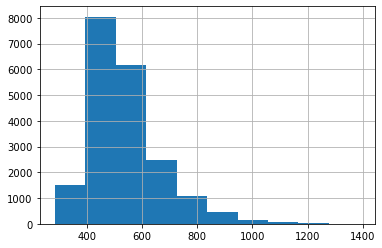

In [34]:
df_reduced["avgavgMMR"].hist()

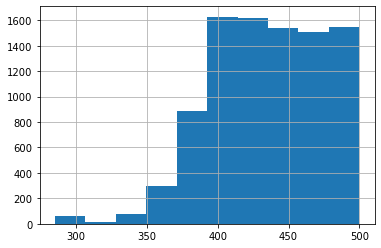

In [35]:
df_reduced.loc[df_reduced["avgavgMMR"] < 500]["avgavgMMR"].hist()

In [37]:
len(df_reduced)

20000

In [71]:
len(df_reduced.loc[df_reduced["avgavgMMR"] < 500])

9167

In [72]:
len(df_reduced.loc[df_reduced["avgavgMMR"] < 500]) / len(df_reduced)

0.45835

In [73]:
low_avg_df = df_reduced.loc[df_reduced["avgavgMMR"] < 500]

In [74]:
def get_unique_champion_id_list():
    all_match_participants = list(low_avg_df["participants"].apply(lambda x: json.loads(x)))
    all_match_champion_ids = map(lambda participants: [participant["championId"] for participant in participants], all_match_participants)
    flattened_champion_ids = [item for sublist in all_match_champion_ids for item in sublist]
    return list(set(flattened_champion_ids))

In [75]:
unique_champ_id_list = get_unique_champion_id_list()

In [76]:
def make_team_comp_vector(team_id, participants_json, unique_champion_ids):
    champ_id_to_vec_pos_mapping = {unique_champion_ids[i]: i for i in range(len(unique_champion_ids))}
    vec = np.zeros(len(unique_champion_ids))
    for participant in json.loads(participants_json):
        if participant["teamId"] != team_id:
            continue
        
        vec_pos = champ_id_to_vec_pos_mapping[participant["championId"]]
        vec[vec_pos] = 1
    return vec

In [77]:
def make_match_vector(participants_json, unique_champ_id_list):
    team100_vector = make_team_comp_vector(100, participants_json, unique_champ_id_list)
    team200_vector = make_team_comp_vector(200, participants_json, unique_champ_id_list)
    return np.concatenate((team100_vector, team200_vector))

In [78]:
def make_match_result(teams_json):
    # returns 1 if team100 won
    # otherwise 0
    team_dict = json.loads(teams_json)[0]
    team_id = team_dict["teamId"]
    team_win = team_dict["win"]
    if team_id == 100:
        return 1 if team_win == "Win" else 0
    if team_id == 200:
        return 0 if team_win == "Win" else 1

In [79]:
X = []
y = []
for i in low_avg_df.index:
    try:
        participants_json = low_avg_df.iloc[i]["participants"]
        teams_json = low_avg_df.iloc[i]["teams"]
    except IndexError:
        continue
        
    X.append(make_match_vector(participants_json, unique_champ_id_list))
    y.append(make_match_result(teams_json))
    
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(3838, 298)
(3838,)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9994)

In [81]:
len(X_train[:,0])

3070

In [82]:
len(X_train[1,:])

298

In [83]:
logreg_class = LogisticRegression(n_jobs=10)
logreg_class.fit(X_train, y_train)

LogisticRegression(n_jobs=10)

In [84]:
logreg_class.score(X_train, y_train)

0.6550488599348534

In [85]:
logreg_class.score(X_test, y_test)

0.5364583333333334

In [86]:
inputs2 = keras.Input(shape=(len(unique_champ_id_list)*2,))
x2 = layers.Dense(32, activation="relu")(inputs2)
x2 = layers.Dense(16, activation="relu")(x2)
x2 = layers.Dense(8, activation="relu")(x2)
output2 = layers.Dense(1, activation='sigmoid')(x2)
model2 = keras.Model(inputs=inputs2, outputs=output2)
model2.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model2.fit(X_train, y_train, epochs=10, batch_size=8)
model2.evaluate(X_test, y_test)

Epoch 1/10
3070/3070 [==============================] - 2s 514us/sample - loss: 0.6902 - acc: 0.5309
Epoch 2/10
3070/3070 [==============================] - 1s 386us/sample - loss: 0.6545 - acc: 0.6339
Epoch 3/10
3070/3070 [==============================] - 1s 422us/sample - loss: 0.5923 - acc: 0.6977
Epoch 4/10
3070/3070 [==============================] - 1s 410us/sample - loss: 0.5125 - acc: 0.7622
Epoch 5/10
3070/3070 [==============================] - 1s 414us/sample - loss: 0.4101 - acc: 0.8336
Epoch 6/10
3070/3070 [==============================] - 1s 434us/sample - loss: 0.3063 - acc: 0.8850
Epoch 7/10
3070/3070 [==============================] - 1s 412us/sample - loss: 0.2060 - acc: 0.9362
Epoch 8/10
3070/3070 [==============================] - 1s 408us/sample - loss: 0.1285 - acc: 0.9687
Epoch 9/10
3070/3070 [==============================] - 2s 636us/sample - loss: 0.0733 - acc: 0.9827
Epoch 10/10
768/768 [==============================] - 0s 194us/sample - loss: 1.8778 - acc

[1.8777858763933182, 0.546875]

In [53]:
inputs3 = keras.Input(shape=(len(unique_champ_id_list)*2,))
x3 = layers.Dense(64, activation="relu")(inputs3)
x3 = layers.Dense(32, activation="relu")(x3)
x3 = layers.Dense(32, activation="relu")(x3)
x3 = layers.Dense(16, activation="relu")(x3)
output3 = layers.Dense(1, activation='sigmoid')(x3)
model3 = keras.Model(inputs=inputs3, outputs=output3)
model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
model3.fit(X_train, y_train, epochs=40, batch_size=15)
model3.evaluate(X_test, y_test)

Epoch 1/40
3070/3070 [==============================] - 1s 402us/sample - loss: 0.6932 - acc: 0.5101
Epoch 2/40
3070/3070 [==============================] - 1s 326us/sample - loss: 0.6678 - acc: 0.6186
Epoch 3/40
3070/3070 [==============================] - 1s 285us/sample - loss: 0.5786 - acc: 0.7023
Epoch 4/40
3070/3070 [==============================] - 1s 286us/sample - loss: 0.4213 - acc: 0.8218
Epoch 5/40
3070/3070 [==============================] - 1s 264us/sample - loss: 0.2416 - acc: 0.9098
Epoch 6/40
3070/3070 [==============================] - 1s 280us/sample - loss: 0.1070 - acc: 0.9704
Epoch 7/40
3070/3070 [==============================] - 1s 391us/sample - loss: 0.0433 - acc: 0.9899
Epoch 8/40
3070/3070 [==============================] - 1s 279us/sample - loss: 0.0127 - acc: 0.9974
Epoch 9/40
3070/3070 [==============================] - 1s 305us/sample - loss: 0.0038 - acc: 0.9997
Epoch 10/40
3070/3070 [==============================] - 1s 269us/sample - loss: 0.0015 - a

[4.8149474163850146, 0.5130208]